### Computing coherences 

Here we will use a toy model to test our functions to compute coherence

In [1]:
%matplotlib inline

import numpy                 as np
import matplotlib.pyplot     as plt
from   GDa.spectral_analysis import spectral

In [2]:
# Model we will use from Dhamala et. al., (2008)
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    T = N / Fs
    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N])
    Y = np.random.random([Trials, N])

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in range(Trials):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N):
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] +E[t,1]

    Z = np.zeros([2, Trials, N])

    Z[0] = X
    Z[1] = Y

    return Z

#### Single trial

In this example X is coupled to Y (Y$\rightarrow$X), but the coupling is turned of at t = 2.25 s. We will compute the transforms and the coherence for only one trial first.

In [6]:
# Generating signals
N  = 900      # Number of observations
Fs = 200      # Sampling frequency
dt = 1.0 / Fs # Time resolution
C  = 0.25     # Coupling parameter
Trials = 1    # Number of trials

freqs = np.arange(0.1,100,.1)

cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])
Z = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=2.25, cov=cov)
Z = np.swapaxes(Z, 0, 1)
X = np.squeeze(Z[0,0,:])
Y = np.squeeze(Z[0,1,:])

In [10]:
# Instantiating spectral class
spec = spectral()

In [12]:
# Computing wavelet spectra
#1. Morlet
Sxx_ml, Syy_ml, Sxy_ml = spec.wavelet_spectrum(signal1 = X[np.newaxis,np.newaxis,:], 
                                                signal2 = Y[np.newaxis,np.newaxis,:], 
                                                fs = Fs, freqs = freqs, n_cycles = freqs/2.0, 
                                                win_time=500, win_freq=1, time_bandwidth = None, 
                                                method = 'morlet', n_jobs = -1) 
#2. Multitaper
Sxx_mt, Syy_mt, Sxy_mt = spec.wavelet_spectrum(signal1 = X[np.newaxis,np.newaxis,:], 
                                               signal2 = Y[np.newaxis,np.newaxis,:], 
                                               fs = Fs, freqs = freqs, n_cycles = freqs/2.0, 
                                               win_time=500, win_freq=1, time_bandwidth = 8.0, 
                                               method = 'multitaper', n_jobs = -1) 

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.2s finished


Text(0.5, 0, 'Time [s]')

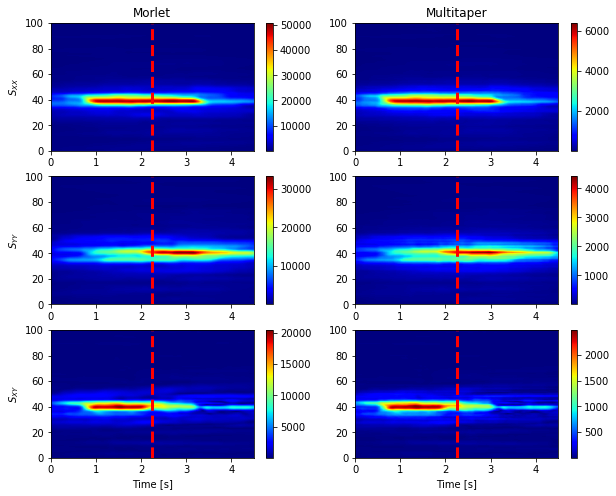

In [14]:
plt.figure(figsize = (10,8))
plt.subplot(3,2,1)
plt.imshow(Sxx_ml.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.title('Morlet')
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.ylabel('$S_{XX}$')
plt.subplot(3,2,2)
plt.imshow(Sxx_mt.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.title('Multitaper')
plt.subplot(3,2,3)
plt.imshow(Syy_ml.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.ylabel('$S_{YY}$')
plt.subplot(3,2,4)
plt.imshow(Syy_mt.real, aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.subplot(3,2,5)
plt.imshow(np.abs(Sxy_ml), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.xlabel('Time [s]')
plt.ylabel('$S_{XY}$')
plt.subplot(3,2,6)
plt.imshow(np.abs(Sxy_mt), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100]); plt.colorbar()
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3)
plt.xlabel('Time [s]')

Now let's compute the coherence

In [17]:
# Computing coherence
C_ml = spec.wavelet_coherence(signal1 = X[np.newaxis,np.newaxis,:], 
                      signal2 = Y[np.newaxis,np.newaxis,:], 
                      fs = Fs, freqs = freqs, n_cycles = freqs/2.0, win_time=500, win_freq=1,
                      time_bandwidth = 8.0, method = 'morlet', n_jobs = -1)

C_mt = spec.wavelet_coherence(signal1 = X[np.newaxis,np.newaxis,:], 
                      signal2 = Y[np.newaxis,np.newaxis,:], 
                      fs = Fs, freqs = freqs, n_cycles = freqs/2.0, win_time=500, win_freq=1,
                      time_bandwidth = 8.0, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.3s finished


Text(0.5, 0, 'Time [s]')

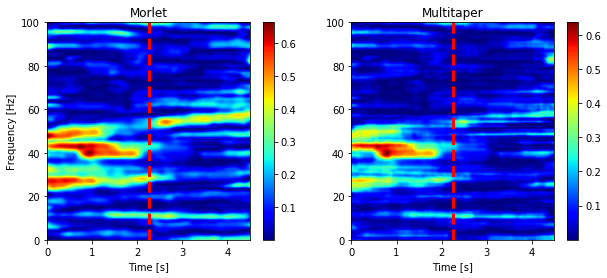

In [18]:
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(C_ml.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100])
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3); plt.colorbar()
plt.title('Morlet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(C_mt.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[0,dt*900,0.1,100])
plt.vlines(2.25, 0.1, 100, colors='r', linestyles='--', lw=3); plt.colorbar()
plt.title('Multitaper')
plt.xlabel('Time [s]')